In [1]:
import numpy as np 
import pandas as pd
import os
import cv2
import tensorflow
import glob
from matplotlib import pyplot as plt
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten,Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.applications import EfficientNetB0
import tensorflow as tf 
from tensorflow.keras import layers
!pip install --quiet vit-keras
from vit_keras import vit
from tensorflow.keras.applications.resnet50 import ResNet50


In [2]:
import tensorflow_hub as hub

In [3]:
# ucm
# test_data=pd.read_csv("/kaggle/input/satelite-images/Images/test.csv")
# test_data['File']=test_data['File'].apply(lambda x : '/kaggle/input/satelite-images/Images/'+x)
# links=[
#     "/kaggle/input/ucm-1-vit-1-cnn-models/1vit1cnn.h5",
#     "/kaggle/input/ucm-1-vit-1-cnn-models/1vit1cnndensenet.h5",
#     "/kaggle/input/ucm-1-vit-1-cnn-models/1vit1cnniresnet.h5",
#     "/kaggle/input/ucm-1-vit-1-cnn-models/1vit1cnnxception.h5"
# ]

In [4]:
# rsscn7
# test_data=pd.read_csv("/kaggle/input/rsscn7-dataset/gamma-correct/test.csv")
# test_data['File']=test_data['File'].apply(lambda x : '/kaggle/input/rsscn7-dataset/gamma-correct/'+x)
# links=[
#     "/kaggle/input/rsscn7-models-1-vit-1-cnn/1vit1cnn.h5",
#     "/kaggle/input/rsscn7-models-1-vit-1-cnn/1vit1cnndensenet.h5",
#     "/kaggle/input/rsscn7-models-1-vit-1-cnn/1vit1cnniresnet.h5",
#     "/kaggle/input/rsscn7-models-1-vit-1-cnn/1vit1cnnxception.h5"
# ]

In [5]:
test_data=pd.read_csv("/kaggle/input/msrsi-dataset/MSRSI/test_df.csv")
test_data['File']=test_data['File'].apply(lambda x : '/kaggle/input/msrsi-dataset/MSRSI/'+x)
links=[
    "/kaggle/input/msris-dataset-models/1vit1cnndensenet.h5",
    "/kaggle/input/msris-dataset-models/1vit1cnniresnet.h5",
    "/kaggle/input/msris-dataset-models/1vit1cnnresnet152v2.h5",
    "/kaggle/input/msris-dataset-models/1vit1cnnxception.h5"
]

In [6]:
SIZE=448
size = [SIZE, SIZE ,3]

In [7]:
test_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
)
batch_size=16
test_images = test_generator.flow_from_dataframe(
    dataframe=test_data,
    x_col='File',
    y_col='class_',
    target_size=(SIZE, SIZE),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=batch_size,
    shuffle=False
)

Found 6000 validated image filenames belonging to 15 classes.


In [8]:
def prediction_generator(test_images):
    k=0
    for x in test_images:
        k+=len(x[1])
        yield [x[0],x[0]], x[1]
        if(k>=test_images.n):
            break


In [9]:
models=[]
predictions = []

In [10]:
def soft_vote(links):
    global models
    global predictions
    global test_images
    if(len(models)==0):
        for i in links:
            models.append(tf.keras.models.load_model(i,custom_objects={'KerasLayer':hub.KerasLayer}, compile=False))
    
    if(len(predictions)==0):
        for model in models:
            predictions.append(model.predict(prediction_generator(test_images)))

    # Calculate average probability across all models for each class
    ensemble_predictions = np.mean(predictions, axis=0)

    # Convert to class labels
    class_labels = np.argmax(ensemble_predictions, axis=1)
    return class_labels, ensemble_predictions

In [11]:
y_pred,proba=soft_vote(links)
from sklearn.metrics import accuracy_score
y_test=test_images.labels
accuracy_score(y_test,y_pred)

0.9545

In [12]:
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score,matthews_corrcoef
# proba=model.predict(prediction_generator(test_images))
predicted =  y_pred #np.argmax(proba,axis=1)
true=y_test # test_images.labels
print("acc: ", accuracy_score(predicted, true))
print("preci: ", precision_score(predicted, true,average='weighted'))
print("recall: ", recall_score(predicted, true,average='weighted'))
print("f1: ", f1_score(predicted, true,average='weighted'))
print("mcc: ", matthews_corrcoef(predicted, true))


acc:  0.9545
preci:  0.9548633333333334
recall:  0.9545
f1:  0.9544574142171272
mcc:  0.9512822195684261


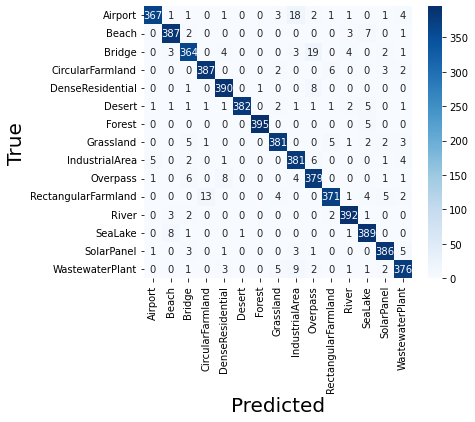

In [13]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

class_ = test_images.class_indices.keys()
cm = confusion_matrix(true, predicted)

fig = plt.figure(figsize=(6, 5))
ax = plt.subplot()

sns.heatmap(cm, annot=True, fmt='d', ax=ax, cmap="Blues")  # Correct format to integers
ax.set_xlabel('Predicted', fontsize=20)
ax.xaxis.set_label_position('bottom')
plt.xticks(rotation=90)
ax.xaxis.set_ticklabels(class_, fontsize=10)
ax.xaxis.tick_bottom()

ax.set_ylabel('True', fontsize=20)
ax.yaxis.set_ticklabels(class_, fontsize=10)
plt.yticks(rotation=0)

plt.title('', fontsize=60)

plt.savefig('ConMat24.png')
plt.show()

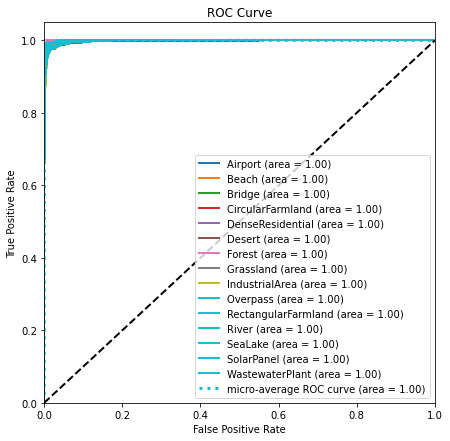

In [14]:
from sklearn.metrics import roc_curve, roc_auc_score
from matplotlib import cm
n=len(true)
dim=max(true)+1
result=[]
for i in true:
    result.append([0 for i in range(dim)])
    result[len(result)-1][i]=1
    
    
fpr = dict()
tpr = dict()
roc_auc = dict()
n_classes =len(test_images.class_indices.keys())
y_test=np.array(result)
y_pred=np.array(proba)
fpr = dict()
tpr = dict()
roc_auc = dict()

rev={}
for i in class_:
    rev[test_images.class_indices[i]]=i


for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_pred[:, i])
    roc_auc[i] = roc_auc_score(y_test[:, i], y_pred[:, i])


fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_pred.ravel())
roc_auc["micro"] = roc_auc_score(y_test, y_pred, multi_class='ovr')


cmap = cm.get_cmap('tab10')

# Plot the ROC curve for each class and micro-average with automatic color selection
plt.figure(figsize=(7,7))
lw = 2
for i in range(n_classes):
    color = cmap(i)
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='{0} (area = {1:0.2f})'
             ''.format(rev[i], roc_auc[i]))

plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
         ''.format(roc_auc["micro"]),
         color=cmap(n_classes), linestyle=':', linewidth=3)

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()


In [15]:
def perf_measure(y_actual, y_hat):
    TP = 0
    FP = 0
    TN = 0
    FN = 0

    for i in range(len(y_hat)): 
        if y_actual[i]==y_hat[i]==1:
           TP += 1
        if y_hat[i]==1 and y_actual[i]!=y_hat[i]:
           FP += 1
        if y_actual[i]==y_hat[i]==0:
           TN += 1
        if y_hat[i]==0 and y_actual[i]!=y_hat[i]:
           FN += 1

    return(TP, FP, TN, FN)


In [16]:
TP,FP,TN,FN=perf_measure(true,predicted)
# Sensitivity, hit rate, recall, or true positive rate
TPR = TP/(TP+FN)
# Specificity or true negative rate
TNR = TN/(TN+FP) 
# Precision or positive predictive value
PPV = TP/(TP+FP)
# Negative predictive value
NPV = TN/(TN+FN)
# Fall out or false positive rate
FPR = FP/(FP+TN)
# False negative rate
FNR = FN/(TP+FN)
# False discovery rate
FDR = FP/(TP+FP)

In [17]:
print('true positive rate',TPR)
print('true negative rate',TNR)
print('Positive predictive value',PPV)
print('negative predictive value',NPV)
print('false positive rate',FPR)
print('false negative rate',FNR)
print('false discovery rate',FDR)

true positive rate 0.979746835443038
true negative rate 0.95822454308094
Positive predictive value 0.9602977667493796
negative predictive value 0.9786666666666667
false positive rate 0.04177545691906005
false negative rate 0.020253164556962026
false discovery rate 0.03970223325062035
